In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/데이터/train_processed.csv'
train_df = pd.read_csv(file_path)

In [66]:
submit_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/test_processed.csv')

In [42]:
!pip install optuna

In [43]:
!pip install catboost

In [44]:
import pandas as pd
import numpy as np


import warnings
import matplotlib.pyplot as plt
import matplotlib

# 모든 matplotlib 경고 무시
warnings.filterwarnings('ignore')
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb


import sqlite3
import optuna
from optuna import Trial
from optuna.samplers import TPESampler


import warnings
warnings.filterwarnings('ignore')

In [45]:
import os

study_name = "dacon_temp_xgb_label_v1"
storage_name = f"sqlite:///optuna/{study_name}.db"

# 데이터베이스 파일 저장 경로 설정
db_dir = "/content/optuna"  # Colab 작업 디렉토리 내 optuna 폴더
os.makedirs(db_dir, exist_ok=True)  # 폴더가 없으면 생성
storage_name = f"sqlite:///{db_dir}/{study_name}.db"  # 절대 경로 사용

In [46]:
target_df = train_df['가격(백만원)']
train_df = train_df.drop(columns=['가격(백만원)'])

train_df, test_df, target_df, test_target_df = train_test_split(train_df,target_df, test_size=0.2, random_state=42)

In [47]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 각 모델의 objective 함수 정의
def objectiveLR_xgb(trial: Trial, train_df, target_df, test_df, test_target_df):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
  }
  model = xgb.XGBRegressor(objective = 'reg:squarederror', **params)
  model.fit(train_df, target_df)
  predictions = model.predict(test_df)
  rmse = np.sqrt(mean_squared_error(test_target_df, predictions))
  return rmse

def objectiveLR_rf(trial: Trial, train_df, target_df, test_df, test_target_df):

  params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }
  model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
  model.fit(train_df, target_df)
  predictions = model.predict(test_df)
  rmse = np.sqrt(mean_squared_error(test_target_df, predictions))
  return rmse

def objectiveLR_catboost(trial: Trial, train_df, target_df, test_df, test_target_df):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0)
    }
    model = CatBoostRegressor(**params, verbose=False, random_state=42)
    model.fit(train_df, target_df)
    predictions = model.predict(test_df)
    rmse = np.sqrt(mean_squared_error(test_target_df, predictions))
    return rmse

# 각 모델 최적화

In [48]:
# 각 모델 최적화
def optimize_model(model_name, objective_func, train_df, target_df, test_df, test_target_df):
    study_name = f"dacon_temp_{model_name}_v1"
    storage_name = f"sqlite:///optuna/{study_name}.db"

    try:
        study = optuna.create_study(
            storage=storage_name,
            study_name=study_name,
            direction='minimize',
            sampler=TPESampler(multivariate=True, n_startup_trials=50, seed=42)
        )
        print(f"{model_name}: create new study")
    except:
        study = optuna.load_study(study_name=study_name, storage=storage_name)
        print(f"{model_name}: load existing study")

    study.optimize(
        lambda trial: objective_func(trial, train_df, target_df, test_df, test_target_df),
        n_trials=50
    )
    return study

# 최적화된 모델로 예측

In [49]:
def get_optimized_predictions(model_name, study, train_df, target_df, test_df):
    if model_name == 'xgb':
        model = xgb.XGBRegressor(objective='reg:squarederror', **study.best_params)
    elif model_name == 'rf':
        model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    else:  # catboost
        model = CatBoostRegressor(**study.best_params, verbose=False, random_state=42)

    model.fit(train_df, target_df)
    return model.predict(test_df)

# 모델 최적화

In [50]:
print("=== 모델 최적화 시작 ===")

study_xgb = optimize_model('xgb', objectiveLR_xgb, train_df, target_df, test_df, test_target_df)
study_rf = optimize_model('rf', objectiveLR_rf, train_df, target_df, test_df, test_target_df)
study_catboost = optimize_model('catboost', objectiveLR_catboost, train_df, target_df, test_df, test_target_df)

# 각 모델의 예측
pred_xgb = get_optimized_predictions('xgb', study_xgb, train_df, target_df, test_df)
pred_rf = get_optimized_predictions('rf', study_rf, train_df, target_df, test_df)
pred_catboost = get_optimized_predictions('catboost', study_catboost, train_df, target_df, test_df)

=== 모델 최적화 시작 ===
xgb: load existing study


[I 2025-01-11 10:42:30,281] Trial 100 finished with value: 2.410759099688459 and parameters: {'n_estimators': 155, 'max_depth': 10, 'learning_rate': 0.019326759259313864, 'min_child_weight': 5, 'subsample': 0.6452180418611717, 'colsample_bytree': 0.8213820156337266, 'gamma': 3.322256981164363e-07}. Best is trial 79 with value: 1.4366313080141977.
[I 2025-01-11 10:42:34,037] Trial 101 finished with value: 1.4906549707234018 and parameters: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.01569581683461215, 'min_child_weight': 5, 'subsample': 0.6103239074656746, 'colsample_bytree': 0.8597215694716412, 'gamma': 2.998624884190238e-08}. Best is trial 79 with value: 1.4366313080141977.
[I 2025-01-11 10:42:34,558] Trial 102 finished with value: 1.569162386566924 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.02368438814898747, 'min_child_weight': 5, 'subsample': 0.6229429871048273, 'colsample_bytree': 0.8766150686942603, 'gamma': 7.958320355712271e-08}. Best

rf: load existing study


[I 2025-01-11 10:43:14,093] Trial 100 finished with value: 1.3845899036780105 and parameters: {'n_estimators': 754, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.7880885992886755}. Best is trial 100 with value: 1.3845899036780105.
[I 2025-01-11 10:43:16,767] Trial 101 finished with value: 1.3865437932913967 and parameters: {'n_estimators': 705, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.8329517349160579}. Best is trial 100 with value: 1.3845899036780105.
[I 2025-01-11 10:43:19,914] Trial 102 finished with value: 1.387727808780531 and parameters: {'n_estimators': 743, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.8635245905520941}. Best is trial 100 with value: 1.3845899036780105.
[I 2025-01-11 10:43:22,683] Trial 103 finished with value: 1.3871658404464464 and parameters: {'n_estimators': 733, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 

catboost: load existing study


[I 2025-01-11 10:45:01,001] Trial 100 finished with value: 1.4299565204880587 and parameters: {'iterations': 566, 'learning_rate': 0.019425451631730574, 'depth': 8, 'l2_leaf_reg': 0.00020208219406410685, 'border_count': 85, 'bagging_temperature': 0.9487239925813694}. Best is trial 85 with value: 1.394985764764336.
[I 2025-01-11 10:45:02,645] Trial 101 finished with value: 1.3858375979530766 and parameters: {'iterations': 503, 'learning_rate': 0.027482592902514643, 'depth': 9, 'l2_leaf_reg': 0.0005750152688154109, 'border_count': 104, 'bagging_temperature': 0.969875909760585}. Best is trial 101 with value: 1.3858375979530766.
[I 2025-01-11 10:45:04,749] Trial 102 finished with value: 1.443604205696018 and parameters: {'iterations': 533, 'learning_rate': 0.028655950464720182, 'depth': 10, 'l2_leaf_reg': 0.0006331264798617159, 'border_count': 97, 'bagging_temperature': 0.9674047343958845}. Best is trial 101 with value: 1.3858375979530766.
[I 2025-01-11 10:45:06,028] Trial 103 finished wit

# 앙상블

In [51]:
# 단순 평균
ensemble_mean = (pred_xgb + pred_rf + pred_catboost) / 3

#가중치 기반 앙상블
weights = [
    1/study_xgb.best_value,
    1/study_rf.best_value,
    1/study_catboost.best_value
]
weights = np.array(weights) / sum(weights)

ensemble_weighted = (
    weights[0] * pred_xgb +
    weights[1] * pred_rf +
    weights[2] * pred_catboost
)

# 결과 평가

In [52]:
print("\n=== 모델 성능 비교 ===")
results = {
    'Model': ['XGBoost', 'RandomForest', 'CatBoost', 'Ensemble(Mean)', 'Ensemble(Weighted)'],
    'RMSE': [
        np.sqrt(mean_squared_error(test_target_df, pred_xgb)),
        np.sqrt(mean_squared_error(test_target_df, pred_rf)),
        np.sqrt(mean_squared_error(test_target_df, pred_catboost)),
        np.sqrt(mean_squared_error(test_target_df, ensemble_mean)),
        np.sqrt(mean_squared_error(test_target_df, ensemble_weighted))
    ],
    'R2': [
        r2_score(test_target_df, pred_xgb),
        r2_score(test_target_df, pred_rf),
        r2_score(test_target_df, pred_catboost),
        r2_score(test_target_df, ensemble_mean),
        r2_score(test_target_df, ensemble_weighted)
    ]
}

results_df = pd.DataFrame(results)
print(results_df.round(4))


=== 모델 성능 비교 ===
                Model    RMSE      R2
0             XGBoost  1.4336  0.9985
1        RandomForest  1.3808  0.9986
2            CatBoost  1.3858  0.9986
3      Ensemble(Mean)  1.3813  0.9986
4  Ensemble(Weighted)  1.3808  0.9986


# 결과 시각화

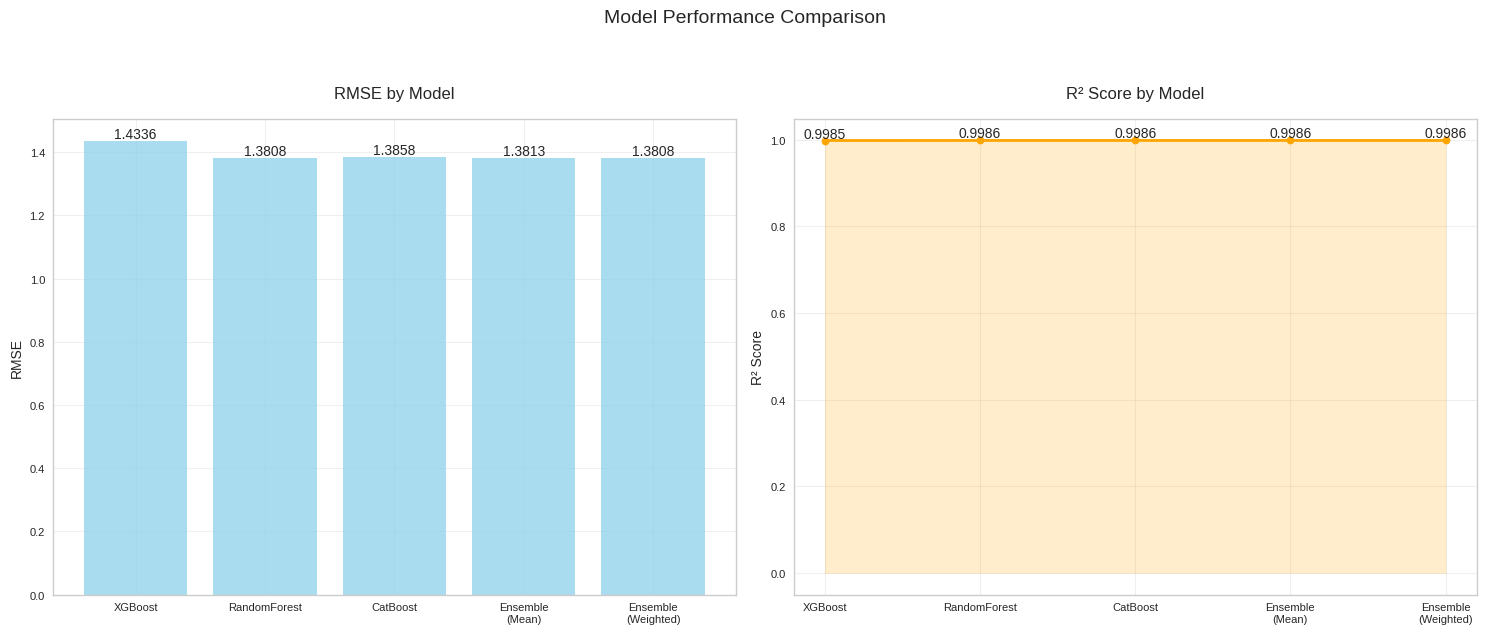

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 설정
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 데이터 준비
models = ['XGBoost', 'RandomForest', 'CatBoost', 'Ensemble\n(Mean)', 'Ensemble\n(Weighted)']
rmse_values = results_df['RMSE'].values
r2_values = results_df['R2'].values

# RMSE 바 플롯
bars = ax1.bar(models, rmse_values, color='skyblue', alpha=0.7)
ax1.set_title('RMSE by Model', fontsize=12, pad=15)
ax1.set_ylabel('RMSE', fontsize=10)
ax1.grid(True, alpha=0.3)

# 바 위에 값 표시
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

# R2 Score 라인 플롯
ax2.plot(models, r2_values, marker='o', linewidth=2, color='orange')
ax2.fill_between(models, r2_values, alpha=0.2, color='orange')
ax2.set_title('R² Score by Model', fontsize=12, pad=15)
ax2.set_ylabel('R² Score', fontsize=10)
ax2.grid(True, alpha=0.3)

# R2 값 표시
for i, r2 in enumerate(r2_values):
    ax2.text(i, r2, f'{r2:.4f}', ha='center', va='bottom')

# 전체 그래프 설정
plt.suptitle('Model Performance Comparison', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# 테스트 데이터 추론

# 랜덤 포레스트

In [53]:
pred_submit_rf = get_optimized_predictions('rf', study_rf, train_df, target_df, submit_test_df)

# 최종 예측 결과
y_pred = pred_submit_rf

In [54]:
# sample_submission.csv 불러오기
sample_submission_path = '/content/drive/MyDrive/Colab Notebooks/데이터/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# y_pred 값을 sample_submission에 삽입
sample_submission['가격(백만원)'] = y_pred

# 제출 파일 저장
output_path = '/content/drive/MyDrive/Colab Notebooks/데이터/RF+optuna submission.csv'
sample_submission.to_csv(output_path, index=False)

print(f"Submission file saved to {output_path}")

Submission file saved to /content/drive/MyDrive/Colab Notebooks/데이터/RF+optuna submission.csv


# 앙상블 가중치

In [55]:
# 각 모델로 submit_test_df 예측
pred_submit_xgb = get_optimized_predictions('xgb', study_xgb, train_df, target_df, submit_test_df)
pred_submit_rf = get_optimized_predictions('rf', study_rf, train_df, target_df, submit_test_df)
pred_submit_catboost = get_optimized_predictions('catboost', study_catboost, train_df, target_df, submit_test_df)

# 가중치 계산
weights = [
    1 / study_xgb.best_value,  # XGBoost의 RMSE 역수
    1 / study_rf.best_value,   # RandomForest의 RMSE 역수
    1 / study_catboost.best_value  # CatBoost의 RMSE 역수
]
weights = np.array(weights) / sum(weights)  # 가중치 정규화

# 가중치 기반 앙상블
ensemble_weighted_submit = (
    weights[0] * pred_submit_xgb +
    weights[1] * pred_submit_rf +
    weights[2] * pred_submit_catboost
)

# 최종 예측 결과
y_pred = ensemble_weighted_submit

In [56]:
# sample_submission.csv 불러오기
sample_submission_path = '/content/drive/MyDrive/Colab Notebooks/데이터/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# y_pred 값을 sample_submission에 삽입
sample_submission['가격(백만원)'] = y_pred

# 제출 파일 저장
output_path = '/content/drive/MyDrive/Colab Notebooks/데이터/RFxgbcatboost+optuna submission.csv'
sample_submission.to_csv(output_path, index=False)

print(f"Submission file saved to {output_path}")

Submission file saved to /content/drive/MyDrive/Colab Notebooks/데이터/RFxgbcatboost+optuna submission.csv


In [57]:
sample_submission

,ID,가격(백만원)
0,TEST_000,130.516537
1,TEST_001,79.836445
2,TEST_002,64.952484
3,TEST_003,34.986315
4,TEST_004,47.713242
...,...,...
841,TEST_841,151.361478
842,TEST_842,38.832843
843,TEST_843,38.781157
844,TEST_844,58.817563
